In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from ast import literal_eval
pd.options.plotting.backend = "plotly"
import plotly.express as px
# from chart_studio import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)
from pandas.plotting import table 
import nltk
import seaborn as sns
%matplotlib inline
import random

In [8]:
data=pd.read_csv("sorted_coded_session_293s_merged.csv")

# Removing infrequent apps.
Infrequent apps are defined as those which make up less than 0.01 percent of the total number of observations. These are removed in this section.

In [9]:
app_count=data.groupby('app_code').size()
app_count=app_count.sort_values(ascending=False)

In [10]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.01].index

In [11]:
print("number of infrequent apps for 0.01 thresshold:",len(infrequent_apps))

number of infrequent apps for 0.01 thresshold: 66757


In [12]:
print("number of frequent apps for 0.01 thresshold:",data.app_code.nunique()-len(infrequent_apps))

number of frequent apps for 0.01 thresshold: 331


In [13]:
data["infrequent_app"]=data.app_code.apply(lambda l: l in infrequent_apps)

In [16]:
data=data[data.infrequent_app!=True]

In [17]:
print("Number of observations after infrequent apps have been removed:",data.shape[0])

Number of observations after infrequent apps have been removed: 214416409


We now remove sessions which only contains one app.

In [18]:
print("Number of sessons including sessions only containing one app:",data.groupby('user_id').session.nunique().sum())

Number of sessons including sessions only containing one app: 74783651


In [19]:
data=pd.merge(data,(data.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

In [20]:
data=data[data.session_length_updated>1]

In [21]:
print("number of observations:",data.shape[0])

number of observations: 182182295


# Preparing the VMSP input
Now that the infrequent apps have been removed, along with session only containing one app, we are ready to construct the text file input used by the VMSP algorithm.

In [36]:
input_string=data.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [37]:
np.savetxt('293sec_sessions_0_01_removed_without_split.txt', input_string.values, fmt='%s')

In [38]:
print("number of updated sessions:",input_string.shape[0])

number of updated sessions: 42549537


In [22]:
print("Number of sessions needed for min. sup. of 0.01 percent:",np.ceil(42549537/100*0.1))

Number of sessions needed for min. sup. of 0.01 percent: 42550.0


# VMSP
Now the VMSP algorithm is run, with a minimum support of 0.1 percent.

In [41]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/293sec_sessions_0_01_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_2293sec_sessions_0_01_removed_without_split_min_sup_0_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.001])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 7326463 ms
 Frequent sequences count : 7378
 Max memory (mb) : 20706.6906051635747378
minsup 42550
Intersection count 68808 


                                                                            pattern  \
0                                                                           [66375]   
1                                                                           [65996]   
2                                                                           [65957]   
3                                                                           [65471]   
4                                                                           [65457]   
...                                                                             ...   
7373         [19968, 53003, 19968, 53003, 19968, 53003, 19968, 19968, 53003, 19968]   
7374         [53003, 19968, 53003, 19968, 53003, 1

## Translating the result

In [23]:
app_dict=dict(zip(data.app_code, data.package_name))

output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_1_translated.csv",index=False)

In [34]:
output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_1_translated.csv")

print("number of length one patterns:",output[output.pattern_length==1].shape[0])
print("longest pattern:",output.pattern_length.max())
print("number of maximal frequent patterns:",output.shape[0])

number of length one patterns: 83
longest pattern: 11
number of maximal frequent patterns: 7378


In [35]:
app_dict=dict(zip(data.app_code, data.package_name))

output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_1_translated.csv",index=False)

output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_1_translated.csv")

print("number of length one patterns:",output[output.pattern_length==1].shape[0])
print("longest pattern:",output.pattern_length.max())
print("number of maximal frequent patterns:",output.shape[0])

number of length one patterns: 16
longest pattern: 5
number of maximal frequent patterns: 175


In [36]:
print("Number of sessions needed for min. sup. of 0.01 percent:",np.ceil(42549537/100*0.5))

Number of sessions needed for min. sup. of 0.01 percent: 212748.0


In [28]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/293sec_sessions_0_01_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_2293sec_sessions_0_01_removed_without_split_min_sup_0_5.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.005])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_5.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 1498553 ms
 Frequent sequences count : 460
 Max memory (mb) : 18649.446907043457460
minsup 212748
Intersection count 3851 


                                        pattern     sup
0                                       [65472]  433163
1                                       [59154]  253212
2                                       [51657]  298882
3                                       [50264]  223984
4                                       [49042]  450561
..                                          ...     ...
455  [53003, 19968, 53003, 19968, 53003, 53003]  234330
456  [53003, 19968, 53003, 53003, 19968, 53003]  228084
457  [53003, 53003, 19968, 53003, 19968, 53003]  228558
458  [53003, 19968, 53003, 19968, 53003, 19968]  260787
459  [19968, 53003, 19968, 53003, 19968, 53003]  238763

[460 rows x 2 columns]


In [100]:
app_dict=dict(zip(data.app_code, data.package_name))

output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_5.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_5_translated.csv",index=False)

output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_5_translated.csv")

print("number of length one patterns:",output[output.pattern_length==1].shape[0])
print("longest pattern:",output.pattern_length.max())
print("number of maximal frequent patterns:",output.shape[0])

number of length one patterns: 31
longest pattern: 6
number of maximal frequent patterns: 460


We continue with the results based on the minimum support of 0.5 percent.

In [3]:
output=pd.read_csv("output_VMSP_293sec_sessions_0_01_removed_without_split_min_sup_0_5_translated.csv")

In [167]:
output.groupby('pattern_length').size()

pattern_length
1     31
2     97
3    183
4    106
5     37
6      6
dtype: int64

To understand the results we start by looking at the set of frequent apps.

In [4]:
output['pattern_str']=output.pattern.str.replace(r'[\[\]\'\s]','')

<ipython-input-4-bfe7d6db6d5a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  output['pattern_str']=output.pattern.str.replace(r'[\[\]\'\s]','')


In [5]:
output_app_count=pd.DataFrame(output["pattern_str"].str.split(',', expand=True).values).apply(pd.value_counts).sum(axis=1).sort_values()

In [6]:
output_app_count=output_app_count.sort_values(ascending=False)

In [7]:
print("Number of frequent apps:",output_app_count.shape[0])

Number of frequent apps: 54


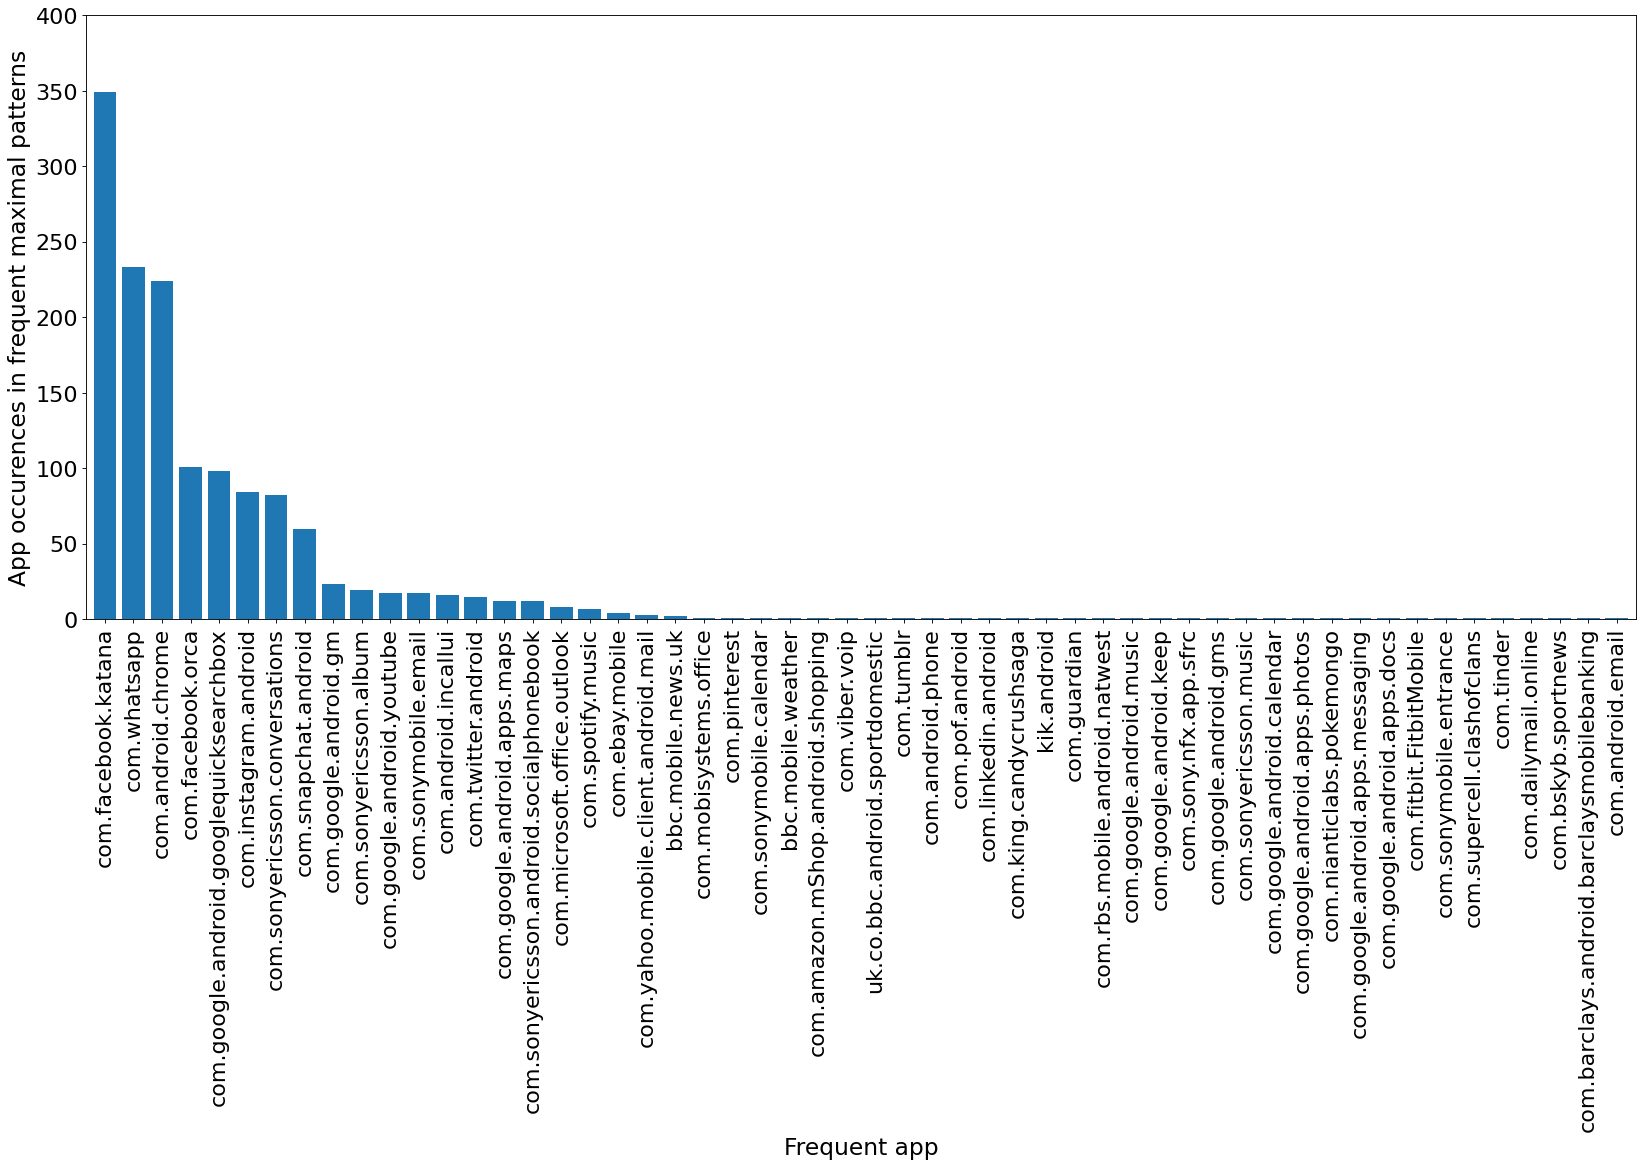

In [8]:
plt.figure(figsize=(25, 10), dpi=80)
bins=plt.bar(output_app_count.index,output_app_count)
plt.ylabel("App occurences in frequent maximal patterns",fontsize=21)
plt.xlabel("Frequent app",fontsize=21)
plt.xticks(rotation=90,fontsize=20) 
plt.yticks(np.arange(0, 451, 50),fontsize=20)
plt.ylim(0,400)
plt.margins(0.005)
plt.savefig("app_count_in_frequent_patterns_293.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=1)
plt.show()

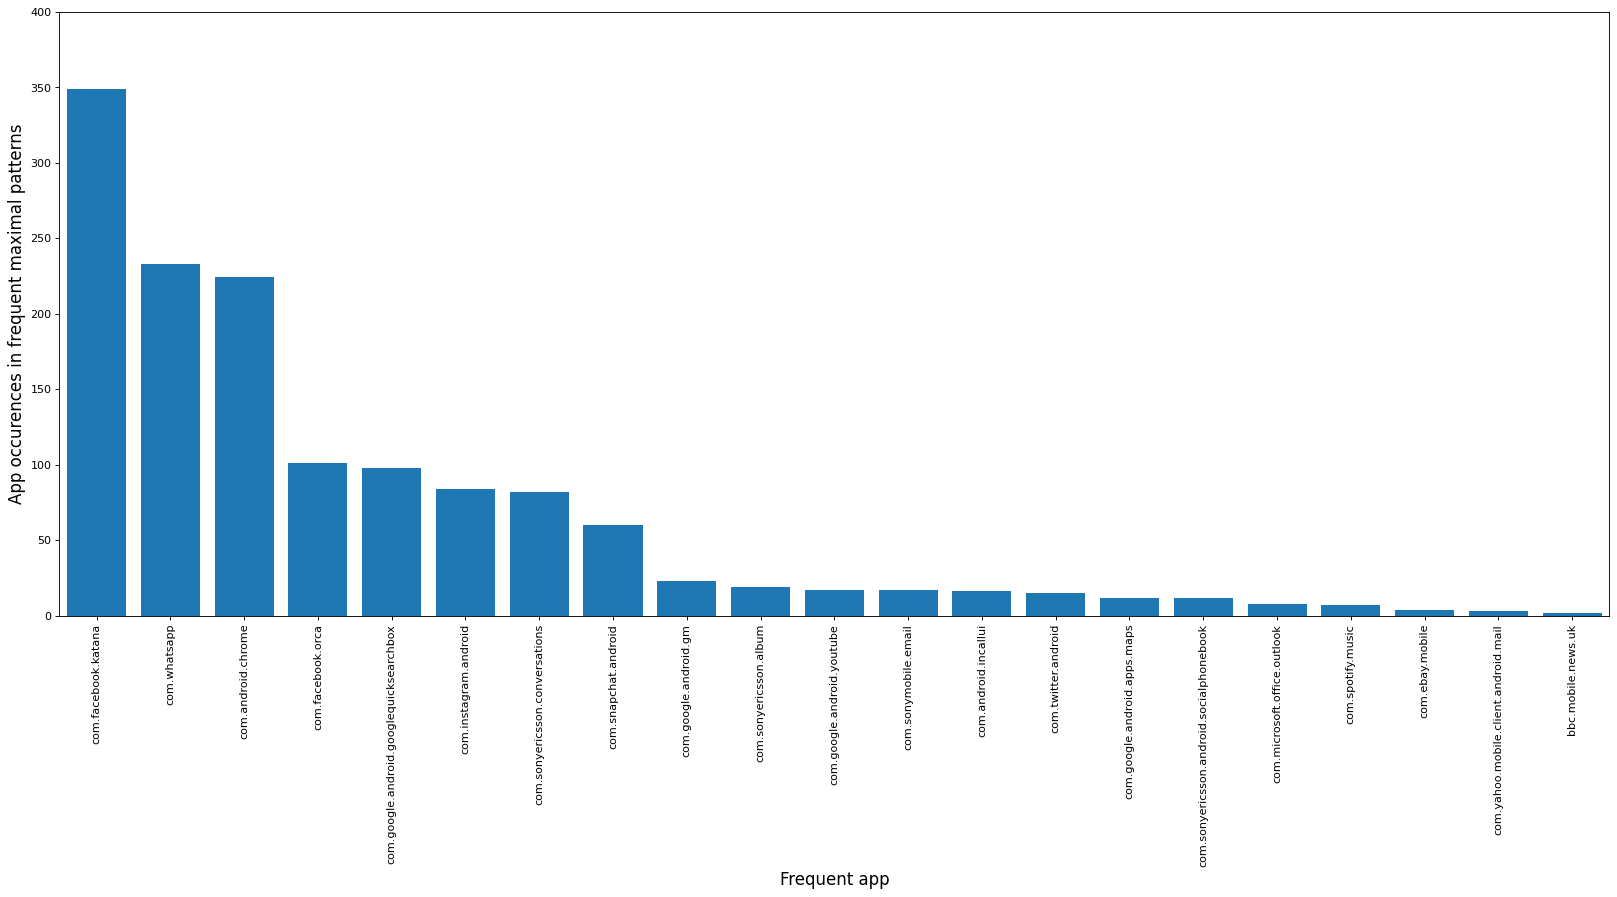

In [9]:
plt.figure(figsize=(25, 10), dpi=80)
bins=plt.bar(output_app_count[output_app_count>1].index,output_app_count[output_app_count>1])
plt.ylabel("App occurences in frequent maximal patterns",fontsize=15)
plt.xlabel("Frequent app",fontsize=15)
plt.xticks(rotation=90,fontsize=10) 
plt.yticks(np.arange(0, 451, 50),fontsize=10)
plt.ylim(0,400)
plt.margins(0.005)
plt.savefig("app_count_293s_more_than_once.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=1)
plt.show()

Not suprisingly it is the overall most common apps which occur most time in the maximal frequent patterns.

When manualy looking through the maximal patterns many of the longer patterns appear similar. To investigate this, we identify the set of apps which occur in each of the patterns.

In [10]:
output['number_of_different_apps']=output.pattern.apply(literal_eval).apply(lambda l:len(set(l)))

In [11]:
output[output.pattern_length==2]['number_of_different_apps'].value_counts()

2    92
1     5
Name: number_of_different_apps, dtype: int64

In [12]:
output[output.pattern_length==3]['number_of_different_apps'].value_counts()

2    91
3    91
1     1
Name: number_of_different_apps, dtype: int64

In [13]:
output[output.pattern_length==4]['number_of_different_apps'].value_counts()

2    51
3    50
1     5
Name: number_of_different_apps, dtype: int64

In [14]:
output[output.pattern_length==5]['number_of_different_apps'].value_counts()

2    36
1     1
Name: number_of_different_apps, dtype: int64

In [15]:
output[output.pattern_length==6]['number_of_different_apps'].value_counts()

2    5
1    1
Name: number_of_different_apps, dtype: int64

While the above numbers show that especially for the longer patterns they contain revisits to at least one app. It is still interesting to see where the patterns contain similar apps.

In [16]:
patterns_longer_than_1=output[output.pattern_length>1]

In [17]:
patterns_longer_than_1["set_of_apps"]=patterns_longer_than_1.pattern.apply(literal_eval).apply(lambda l:set(l))
patterns_longer_than_1['str set']=patterns_longer_than_1.set_of_apps.apply(lambda l: str(sorted(list(l))))
patterns_longer_than_1.groupby('str set').size().sort_values(ascending=False)[patterns_longer_than_1.groupby('str set').size().sort_values(ascending=False)>1]

<ipython-input-17-36efc668ac30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patterns_longer_than_1["set_of_apps"]=patterns_longer_than_1.pattern.apply(literal_eval).apply(lambda l:set(l))
<ipython-input-17-36efc668ac30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patterns_longer_than_1['str set']=patterns_longer_than_1.set_of_apps.apply(lambda l: str(sorted(list(l))))


str set
['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']                               21
['com.facebook.katana', 'com.whatsapp']                                                     18
['com.android.chrome', 'com.facebook.katana', 'com.google.android.googlequicksearchbox']    15
['com.facebook.katana', 'com.facebook.orca']                                                11
['com.android.chrome', 'com.whatsapp']                                                      11
                                                                                            ..
['com.facebook.katana', 'com.microsoft.office.outlook']                                      2
['com.facebook.katana', 'com.sonyericsson.android.socialphonebook']                          2
['com.android.chrome', 'com.facebook.katana', 'com.sonymobile.email']                        2
['com.facebook.katana', 'com.google.android.youtube']                                        2
['com.sonyericsson.album', 'com.sonyericss

In [19]:
patterns_longer_than_1.groupby('str set').size().sort_values(ascending=False).head(20)

str set
['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']                               21
['com.facebook.katana', 'com.whatsapp']                                                     18
['com.android.chrome', 'com.facebook.katana', 'com.google.android.googlequicksearchbox']    15
['com.facebook.katana', 'com.facebook.orca']                                                11
['com.android.chrome', 'com.whatsapp']                                                      11
['com.android.chrome', 'com.facebook.katana']                                               11
['com.android.chrome', 'com.google.android.googlequicksearchbox']                            9
['com.facebook.katana', 'com.sonyericsson.conversations']                                    9
['com.facebook.katana', 'com.instagram.android']                                             7
['com.facebook.katana', 'com.snapchat.android', 'com.whatsapp']                              6
['com.facebook.katana', 'com.instagram.and

In [18]:
patterns_longer_than_1.groupby('str set').size().sort_values(ascending=False)[patterns_longer_than_1.groupby('str set').size().sort_values(ascending=False)>1].sum()

388

As we can clearly see, the majority of the 460 patterns describe similar relationshis as at least one other pattern as they contains patterns with the same apps.

In [128]:
patterns_longer_than_1[patterns_longer_than_1['str set']=="['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps,set_of_apps,str set
125,"['com.whatsapp', 'com.facebook.katana', 'com.whatsapp', 'com.android.chrome']",312134,4,"com.whatsapp,com.facebook.katana,com.whatsapp,com.android.chrome",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
143,"['com.whatsapp', 'com.facebook.katana', 'com.android.chrome', 'com.facebook.katana']",305548,4,"com.whatsapp,com.facebook.katana,com.android.chrome,com.facebook.katana",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
158,"['com.whatsapp', 'com.facebook.katana', 'com.android.chrome', 'com.whatsapp']",298482,4,"com.whatsapp,com.facebook.katana,com.android.chrome,com.whatsapp",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
176,"['com.whatsapp', 'com.android.chrome', 'com.whatsapp', 'com.facebook.katana']",291332,4,"com.whatsapp,com.android.chrome,com.whatsapp,com.facebook.katana",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
190,"['com.facebook.katana', 'com.whatsapp', 'com.android.chrome', 'com.whatsapp']",283151,4,"com.facebook.katana,com.whatsapp,com.android.chrome,com.whatsapp",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
200,"['com.facebook.katana', 'com.whatsapp', 'com.facebook.katana', 'com.android.chrome']",279849,4,"com.facebook.katana,com.whatsapp,com.facebook.katana,com.android.chrome",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
237,"['com.facebook.katana', 'com.whatsapp', 'com.android.chrome', 'com.facebook.katana']",267770,4,"com.facebook.katana,com.whatsapp,com.android.chrome,com.facebook.katana",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
241,"['com.facebook.katana', 'com.android.chrome', 'com.whatsapp', 'com.facebook.katana']",266574,4,"com.facebook.katana,com.android.chrome,com.whatsapp,com.facebook.katana",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
258,"['com.whatsapp', 'com.android.chrome', 'com.facebook.katana', 'com.whatsapp']",263158,4,"com.whatsapp,com.android.chrome,com.facebook.katana,com.whatsapp",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"
283,"['com.android.chrome', 'com.whatsapp', 'com.facebook.katana', 'com.whatsapp']",255915,4,"com.android.chrome,com.whatsapp,com.facebook.katana,com.whatsapp",3,"{com.facebook.katana, com.android.chrome, com.whatsapp}","['com.android.chrome', 'com.facebook.katana', 'com.whatsapp']"


In [20]:
patterns_longer_than_1[patterns_longer_than_1['str set']=="['com.android.chrome', 'com.facebook.katana']"]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps,set_of_apps,str set
95,"['com.facebook.katana', 'com.facebook.katana', 'com.android.chrome', 'com.android.chrome']",334964,4,"com.facebook.katana,com.facebook.katana,com.android.chrome,com.android.chrome",2,"{com.android.chrome, com.facebook.katana}","['com.android.chrome', 'com.facebook.katana']"
96,"['com.facebook.katana', 'com.android.chrome', 'com.android.chrome', 'com.android.chrome']",334838,4,"com.facebook.katana,com.android.chrome,com.android.chrome,com.android.chrome",2,"{com.android.chrome, com.facebook.katana}","['com.android.chrome', 'com.facebook.katana']"
135,"['com.android.chrome', 'com.facebook.katana', 'com.android.chrome', 'com.android.chrome']",308916,4,"com.android.chrome,com.facebook.katana,com.android.chrome,com.android.chrome",2,"{com.facebook.katana, com.android.chrome}","['com.android.chrome', 'com.facebook.katana']"
144,"['com.android.chrome', 'com.android.chrome', 'com.facebook.katana', 'com.android.chrome']",304732,4,"com.android.chrome,com.android.chrome,com.facebook.katana,com.android.chrome",2,"{com.facebook.katana, com.android.chrome}","['com.android.chrome', 'com.facebook.katana']"
164,"['com.android.chrome', 'com.facebook.katana', 'com.facebook.katana', 'com.android.chrome']",297041,4,"com.android.chrome,com.facebook.katana,com.facebook.katana,com.android.chrome",2,"{com.facebook.katana, com.android.chrome}","['com.android.chrome', 'com.facebook.katana']"
177,"['com.android.chrome', 'com.android.chrome', 'com.android.chrome', 'com.facebook.katana']",290284,4,"com.android.chrome,com.android.chrome,com.android.chrome,com.facebook.katana",2,"{com.facebook.katana, com.android.chrome}","['com.android.chrome', 'com.facebook.katana']"
182,"['com.android.chrome', 'com.android.chrome', 'com.facebook.katana', 'com.facebook.katana']",287235,4,"com.android.chrome,com.android.chrome,com.facebook.katana,com.facebook.katana",2,"{com.facebook.katana, com.android.chrome}","['com.android.chrome', 'com.facebook.katana']"
269,"['com.facebook.katana', 'com.android.chrome', 'com.facebook.katana', 'com.android.chrome', 'com.facebook.katana']",259535,5,"com.facebook.katana,com.android.chrome,com.facebook.katana,com.android.chrome,com.facebook.katana",2,"{com.android.chrome, com.facebook.katana}","['com.android.chrome', 'com.facebook.katana']"
308,"['com.facebook.katana', 'com.facebook.katana', 'com.facebook.katana', 'com.android.chrome', 'com.facebook.katana']",250334,5,"com.facebook.katana,com.facebook.katana,com.facebook.katana,com.android.chrome,com.facebook.katana",2,"{com.android.chrome, com.facebook.katana}","['com.android.chrome', 'com.facebook.katana']"
321,"['com.facebook.katana', 'com.facebook.katana', 'com.android.chrome', 'com.facebook.katana', 'com.facebook.katana']",246520,5,"com.facebook.katana,com.facebook.katana,com.android.chrome,com.facebook.katana,com.facebook.katana",2,"{com.android.chrome, com.facebook.katana}","['com.android.chrome', 'com.facebook.katana']"


We now take a look at the patterns which have reacuring apps.

In [44]:
dict((pd.Series(literal_eval(output.iloc[455].pattern)).value_counts()))

{'com.android.chrome': 2, 'com.google.android.youtube': 1}

1. How many reoccur
2. What apps reoccur
3. How many times does these apps reoccur
All to try an illustrate our habit of revisiting apps.

In [66]:
app_count_in_pattern=output.pattern.apply(literal_eval).apply(lambda l: pd.Series(l).value_counts())
app_count_in_pattern=app_count_in_pattern.replace(np.nan,0)

In [67]:
app_count_in_pattern

,com.sonyericsson.music,com.nianticlabs.pokemongo,com.amazon.mShop.android.shopping,com.google.android.apps.messaging,com.google.android.youtube,com.android.phone,com.android.chrome,com.google.android.apps.maps,com.facebook.katana,com.google.android.calendar,...,com.google.android.apps.docs,com.sonymobile.entrance,com.google.android.keep,com.guardian,com.mobisystems.office,com.tumblr,com.pof.android,com.dailymail.online,com.sony.nfx.app.sfrc,com.supercell.clashofclans
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Below we see in how many of the maximal patterns the apps are revisitied.

In [68]:
(app_count_in_pattern>1).sum().sort_values(ascending=False)

com.facebook.katana                           91
com.whatsapp                                  63
com.android.chrome                            49
com.facebook.orca                             19
com.google.android.googlequicksearchbox       18
com.sonyericsson.conversations                16
com.instagram.android                         13
com.snapchat.android                          11
com.android.incallui                           2
com.sonyericsson.album                         1
com.spotify.music                              1
com.google.android.apps.maps                   1
com.sonymobile.email                           1
com.google.android.youtube                     1
com.twitter.android                            1
com.microsoft.office.outlook                   1
com.sonyericsson.android.socialphonebook       1
com.google.android.gm                          1
kik.android                                    0
com.google.android.apps.docs                   0
bbc.mobile.news.uk  

Many of the apps which are not found to be revisited within any of the maximal patterns, are expected for instance banking and games are intuitivly seen as a single activity apps. However again the revisits are dominated by apps, whch are overall popular. For the apps which are revisited we look at the highest number of times they are found to be frequently revisited.

In [71]:
revisited_apps=(app_count_in_pattern>1).sum().sort_values(ascending=False)[(app_count_in_pattern>1).sum().sort_values(ascending=False)>0]

In [87]:
app_count_in_pattern[revisited_apps.index].max().sort_values(ascending=False)

com.whatsapp                                6.0
com.facebook.katana                         5.0
com.android.chrome                          4.0
com.facebook.orca                           4.0
com.google.android.googlequicksearchbox     4.0
com.sonyericsson.conversations              4.0
com.snapchat.android                        4.0
com.instagram.android                       3.0
com.google.android.youtube                  2.0
com.sonyericsson.android.socialphonebook    2.0
com.microsoft.office.outlook                2.0
com.twitter.android                         2.0
com.sonyericsson.album                      2.0
com.sonymobile.email                        2.0
com.google.android.apps.maps                2.0
com.spotify.music                           2.0
com.android.incallui                        2.0
com.google.android.gm                       2.0
dtype: float64

not supprisingly it is the popular communication whatsapp which are found to be frequently revisited.\
To try and understand the revisits to non-comunication apps we try and look at what apps occur in between, to see if the revisits can be explained by the use of communication apps in between.

In [209]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.spotify.music']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
60,"['com.spotify.music', 'com.spotify.music']",374297,2,"com.spotify.music,com.spotify.music",1


In [210]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.google.android.apps.maps']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
62,"['com.google.android.apps.maps', 'com.google.android.apps.maps']",373182,2,"com.google.android.apps.maps,com.google.android.apps.maps",1


In [211]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.sonyericsson.album']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
27,"['com.sonyericsson.album', 'com.sonyericsson.album']",449157,2,"com.sonyericsson.album,com.sonyericsson.album",1


In [212]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.twitter.android']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
139,"['com.twitter.android', 'com.android.chrome', 'com.twitter.android']",308034,3,"com.twitter.android,com.android.chrome,com.twitter.android",2


In [214]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.google.android.youtube']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
4,"['com.google.android.youtube', 'com.google.android.youtube']",624847,2,"com.google.android.youtube,com.google.android.youtube",1


In [216]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.instagram.android']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
33,"['com.instagram.android', 'com.instagram.android', 'com.instagram.android']",430631,3,"com.instagram.android,com.instagram.android,com.instagram.android",1
94,"['com.instagram.android', 'com.android.chrome', 'com.instagram.android']",338205,3,"com.instagram.android,com.android.chrome,com.instagram.android",2
104,"['com.instagram.android', 'com.snapchat.android', 'com.instagram.android']",325838,3,"com.instagram.android,com.snapchat.android,com.instagram.android",2
203,"['com.instagram.android', 'com.instagram.android', 'com.android.chrome']",278909,3,"com.instagram.android,com.instagram.android,com.android.chrome",2
208,"['com.snapchat.android', 'com.instagram.android', 'com.instagram.android']",276472,3,"com.snapchat.android,com.instagram.android,com.instagram.android",2
255,"['com.facebook.katana', 'com.instagram.android', 'com.facebook.katana', 'com.instagram.android']",263555,4,"com.facebook.katana,com.instagram.android,com.facebook.katana,com.instagram.android",2
281,"['com.instagram.android', 'com.facebook.katana', 'com.instagram.android', 'com.facebook.katana']",256356,4,"com.instagram.android,com.facebook.katana,com.instagram.android,com.facebook.katana",2
297,"['com.instagram.android', 'com.instagram.android', 'com.snapchat.android']",252492,3,"com.instagram.android,com.instagram.android,com.snapchat.android",2
312,"['com.whatsapp', 'com.instagram.android', 'com.whatsapp', 'com.instagram.android']",249547,4,"com.whatsapp,com.instagram.android,com.whatsapp,com.instagram.android",2
329,"['com.android.chrome', 'com.instagram.android', 'com.instagram.android']",244549,3,"com.android.chrome,com.instagram.android,com.instagram.android",2


In [217]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.snapchat.android']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
70,"['com.snapchat.android', 'com.instagram.android', 'com.snapchat.android']",360063,3,"com.snapchat.android,com.instagram.android,com.snapchat.android",2
169,"['com.snapchat.android', 'com.whatsapp', 'com.snapchat.android']",293464,3,"com.snapchat.android,com.whatsapp,com.snapchat.android",2
204,"['com.snapchat.android', 'com.snapchat.android', 'com.instagram.android']",278889,3,"com.snapchat.android,com.snapchat.android,com.instagram.android",2
236,"['com.instagram.android', 'com.snapchat.android', 'com.snapchat.android']",267972,3,"com.instagram.android,com.snapchat.android,com.snapchat.android",2
284,"['com.whatsapp', 'com.snapchat.android', 'com.snapchat.android']",255640,3,"com.whatsapp,com.snapchat.android,com.snapchat.android",2
325,"['com.snapchat.android', 'com.facebook.orca', 'com.snapchat.android']",245332,3,"com.snapchat.android,com.facebook.orca,com.snapchat.android",2
352,"['com.snapchat.android', 'com.snapchat.android', 'com.snapchat.android', 'com.snapchat.android']",240709,4,"com.snapchat.android,com.snapchat.android,com.snapchat.android,com.snapchat.android",1
389,"['com.snapchat.android', 'com.snapchat.android', 'com.whatsapp']",232066,3,"com.snapchat.android,com.snapchat.android,com.whatsapp",2
396,"['com.snapchat.android', 'com.android.chrome', 'com.snapchat.android']",228700,3,"com.snapchat.android,com.android.chrome,com.snapchat.android",2
405,"['com.snapchat.android', 'com.facebook.katana', 'com.snapchat.android', 'com.facebook.katana']",226056,4,"com.snapchat.android,com.facebook.katana,com.snapchat.android,com.facebook.katana",2


In [219]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.google.android.googlequicksearchbox']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
49,"['com.facebook.katana', 'com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox']",395510,4,"com.facebook.katana,com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox",3
84,"['com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox']",346049,5,"com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox",2
100,"['com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox', 'com.facebook.katana']",331783,4,"com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox,com.facebook.katana",3
132,"['com.google.android.googlequicksearchbox', 'com.whatsapp', 'com.google.android.googlequicksearchbox']",310192,3,"com.google.android.googlequicksearchbox,com.whatsapp,com.google.android.googlequicksearchbox",2
140,"['com.google.android.googlequicksearchbox', 'com.google.android.googlequicksearchbox', 'com.whatsapp']",306449,3,"com.google.android.googlequicksearchbox,com.google.android.googlequicksearchbox,com.whatsapp",2
251,"['com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox', 'com.google.android.googlequicksearchbox', 'com.android.chrome']",264785,5,"com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox,com.google.android.googlequicksearchbox,com.android.chrome",2
277,"['com.whatsapp', 'com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox']",257815,4,"com.whatsapp,com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox",3
286,"['com.google.android.googlequicksearchbox', 'com.google.android.googlequicksearchbox', 'com.google.android.googlequicksearchbox', 'com.google.android.googlequicksearchbox']",254816,4,"com.google.android.googlequicksearchbox,com.google.android.googlequicksearchbox,com.google.android.googlequicksearchbox,com.google.android.googlequicksearchbox",1
289,"['com.android.chrome', 'com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox', 'com.android.chrome']",254076,5,"com.android.chrome,com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox,com.android.chrome",2
314,"['com.facebook.katana', 'com.google.android.googlequicksearchbox', 'com.google.android.googlequicksearchbox', 'com.android.chrome']",249062,4,"com.facebook.katana,com.google.android.googlequicksearchbox,com.google.android.googlequicksearchbox,com.android.chrome",3


In [220]:
output.loc[app_count_in_pattern[app_count_in_pattern['com.android.chrome']>1].index]

,pattern,sup,pattern_length,pattern_str,number_of_different_apps
28,"['com.android.chrome', 'com.android.chrome', 'com.android.chrome', 'com.android.chrome']",445858,4,"com.android.chrome,com.android.chrome,com.android.chrome,com.android.chrome",1
72,"['com.sonyericsson.conversations', 'com.android.chrome', 'com.android.chrome']",359223,3,"com.sonyericsson.conversations,com.android.chrome,com.android.chrome",2
84,"['com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox', 'com.android.chrome', 'com.google.android.googlequicksearchbox']",346049,5,"com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox,com.android.chrome,com.google.android.googlequicksearchbox",2
87,"['com.android.chrome', 'com.facebook.orca', 'com.android.chrome']",343924,3,"com.android.chrome,com.facebook.orca,com.android.chrome",2
90,"['com.android.chrome', 'com.sonyericsson.conversations', 'com.android.chrome']",341238,3,"com.android.chrome,com.sonyericsson.conversations,com.android.chrome",2
93,"['com.facebook.orca', 'com.android.chrome', 'com.android.chrome']",339111,3,"com.facebook.orca,com.android.chrome,com.android.chrome",2
95,"['com.facebook.katana', 'com.facebook.katana', 'com.android.chrome', 'com.android.chrome']",334964,4,"com.facebook.katana,com.facebook.katana,com.android.chrome,com.android.chrome",2
96,"['com.facebook.katana', 'com.android.chrome', 'com.android.chrome', 'com.android.chrome']",334838,4,"com.facebook.katana,com.android.chrome,com.android.chrome,com.android.chrome",2
113,"['com.android.chrome', 'com.google.android.gm', 'com.android.chrome']",320470,3,"com.android.chrome,com.google.android.gm,com.android.chrome",2
123,"['com.instagram.android', 'com.android.chrome', 'com.android.chrome']",312877,3,"com.instagram.android,com.android.chrome,com.android.chrome",2


- Twitter is used with chrome in between, and could indicate the need for information search triggered by content on twitter or access to content linked on twitter. In order words could be an indication of sumplemented functionality between the two apps.
- instagram are used with many different apps, when revisited. However some of them are surounded by whatsapp which can be see as an example of one activity (instagram) being cut up by the communication chain from another app.

We now take a look at which apps occur together

In [114]:
app_count_in_pattern[app_count_in_pattern['com.google.android.youtube']>0].loc[:,(app_count_in_pattern[app_count_in_pattern['com.google.android.youtube']>0]>0).any()].columns

Index(['com.google.android.youtube', 'com.android.chrome',
       'com.facebook.katana', 'com.whatsapp', 'com.sonyericsson.conversations',
       'com.instagram.android', 'com.google.android.googlequicksearchbox',
       'com.snapchat.android', 'com.facebook.orca'],
      dtype='object')

In [ ]:
app_count_in_pattern[app_count_in_pattern['com.google.android.youtube']>0].loc[:,(app_count_in_pattern[app_count_in_pattern['com.google.android.youtube']>0]>0).any()].columns

In [146]:
apps_occuring_together=pd.DataFrame({'App':app_count_in_pattern.columns})

In [147]:
apps_occuring_together['in frequent patterns together']=apps_occuring_together.App.apply(lambda l:set(app_count_in_pattern[app_count_in_pattern[l]>0].loc[:,(app_count_in_pattern[app_count_in_pattern[l]>0]>0).any()].columns))

In [148]:
apps_occuring_together['in frequent patterns together']=apps_occuring_together.apply(lambda l:l['in frequent patterns together']-set([l.App]),axis=1)

In [155]:
apps_occuring_together['in frequent patterns together']=apps_occuring_together['in frequent patterns together'].astype(str)

In [160]:
apps_occuring_together['in frequent patterns together']=apps_occuring_together['in frequent patterns together'].str.replace(r'[\{\}\'\,]','')

<ipython-input-160-a7e55b3278d7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  apps_occuring_together['in frequent patterns together']=apps_occuring_together['in frequent patterns together'].str.replace(r'[\{\}\'\,]','')


In [168]:
apps_occuring_together

,App,in frequent patterns together
0,com.sonyericsson.music,set()
1,com.nianticlabs.pokemongo,set()
2,com.amazon.mShop.android.shopping,set()
3,com.google.android.apps.messaging,set()
4,com.google.android.youtube,com.google.android.googlequicksearchbox com.android.chrome com.sonyericsson.conversations com.snapchat.android com.whatsapp com.facebook.orca com.instagram.android com.facebook.katana
5,com.android.phone,set()
6,com.android.chrome,bbc.mobile.news.uk com.google.android.apps.docs com.google.android.googlequicksearchbox com.sonymobile.email com.sonyericsson.conversations com.instagram.android com.facebook.katana com.microsoft.office.outlook com.google.android.apps.maps com.yahoo.mobile.client.android.mail com.sonyericsson.android.socialphonebook com.spotify.music com.sonyericsson.album com.snapchat.android com.facebook.orca com.twitter.android com.android.incallui com.ebay.mobile com.whatsapp com.google.android.gm com.google.android.youtube
7,com.google.android.apps.maps,com.google.android.googlequicksearchbox com.android.chrome com.sonyericsson.conversations com.facebook.orca com.whatsapp com.facebook.katana
8,com.facebook.katana,bbc.mobile.news.uk com.google.android.googlequicksearchbox com.sony.nfx.app.sfrc com.sonymobile.email com.sonyericsson.conversations com.instagram.android com.microsoft.office.outlook com.google.android.apps.maps com.yahoo.mobile.client.android.mail com.sonyericsson.android.socialphonebook com.spotify.music com.sonyericsson.album com.android.chrome com.snapchat.android com.facebook.orca com.twitter.android com.android.incallui com.ebay.mobile com.whatsapp com.google.android.gm com.google.android.youtube
9,com.google.android.calendar,set()


Many of the popular apps occur with many of the other apps, and it is hard to see if anything stands out.

In [189]:
app_count_communication_apps=app_count_in_pattern[(app_count_in_pattern['com.whatsapp']>0)\
                                                  |(app_count_in_pattern['com.facebook.orca']>0)\
                                                |(app_count_in_pattern['com.sonyericsson.conversations']>0)]

In [193]:
app_count_communication_apps=app_count_communication_apps[((app_count_communication_apps['com.whatsapp']>0)&(app_count_in_pattern['com.facebook.orca']>0)).apply(lambda l: not l)]

<ipython-input-193-f9d6eb575686>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app_count_communication_apps=app_count_communication_apps[((app_count_communication_apps['com.whatsapp']>0)&(app_count_in_pattern['com.facebook.orca']>0)).apply(lambda l: not l)]


In [194]:
app_count_communication_apps=app_count_communication_apps[((app_count_communication_apps['com.whatsapp']>0)&(app_count_in_pattern['com.sonyericsson.conversations']>0)).apply(lambda l: not l)]

<ipython-input-194-0d155762dd6f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app_count_communication_apps=app_count_communication_apps[((app_count_communication_apps['com.whatsapp']>0)&(app_count_in_pattern['com.sonyericsson.conversations']>0)).apply(lambda l: not l)]


In [196]:
app_count_communication_apps=app_count_communication_apps[((app_count_communication_apps['com.facebook.orca']>0)&(app_count_in_pattern['com.sonyericsson.conversations']>0)).apply(lambda l: not l)]

<ipython-input-196-8aeab3f730ca>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app_count_communication_apps=app_count_communication_apps[((app_count_communication_apps['com.facebook.orca']>0)&(app_count_in_pattern['com.sonyericsson.conversations']>0)).apply(lambda l: not l)]


In [202]:
app_count_communication_apps.loc[:,(app_count_communication_apps!=0).any()]

,com.google.android.youtube,com.android.chrome,com.google.android.apps.maps,com.facebook.katana,com.sonyericsson.album,com.android.incallui,com.whatsapp,com.sonyericsson.conversations,com.sonymobile.email,com.instagram.android,com.google.android.googlequicksearchbox,com.google.android.gm,com.microsoft.office.outlook,com.sonyericsson.android.socialphonebook,com.snapchat.android,com.facebook.orca,com.twitter.android,com.spotify.music
15,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
454,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The number of patterns are still very high making it hard to see if they are in similar patterns. While WhatsApp, occur in the most patterns of the three apps, even focusing on the messenger and messaging apps, still yields a large number of apps.

In [203]:
app_count_communication_apps[(app_count_communication_apps['com.whatsapp']>0).apply(lambda l: not l)]

,com.sonyericsson.music,com.nianticlabs.pokemongo,com.amazon.mShop.android.shopping,com.google.android.apps.messaging,com.google.android.youtube,com.android.phone,com.android.chrome,com.google.android.apps.maps,com.facebook.katana,com.google.android.calendar,...,com.google.android.apps.docs,com.sonymobile.entrance,com.google.android.keep,com.guardian,com.mobisystems.office,com.tumblr,com.pof.android,com.dailymail.online,com.sony.nfx.app.sfrc,com.supercell.clashofclans
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
